# Backgroud
+ high school mathematics
+ have knowledge of any programming language

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.nn.parameter import Parameter
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from __future__ import print_function

%matplotlib inline

# Back Propagation (反向传播)
简单理解就是复合函数的链式求导。

机器学习可以认为就是一个function，$y=f(x)$，但是我们如何求解这个function，确定这个function的参数呢？通常会用一个cost function来衡量当前参数的好坏，cost函数也可以看成是由所有待求权值Wij为自变量的复合函数，而且基本上是非凸的，即含有许多局部最小值，但是实际情况下，使用梯度下降法往往就能求解一个cost最小化的问题，梯度下降法需要给定一个初始点，并求出该点的梯度向量，然后以负梯度方向为搜索方向，以一定的步长进行搜索，从而确定下一个迭代点，再计算该新的梯度方向，如此重复直到cost收敛。那么如何计算梯度呢？假设我们把cost函数表示为$H(W_{11}, W_{12}, \cdots , W_{ij}, \cdots, W_{mn})$, 那么它的梯度向量就等于$\nabla H  = \frac{\partial H}{\partial W_{11} }\mathbf{e}_{11} + \cdots + \frac{\partial H}{\partial W_{mn} }\mathbf{e}_{mn}$, 其中$\mathbf{e}_{ij}$表示正交单位向量。为此，我们需求出cost函数H对每一个权值Wij的偏导数。而BP算法正是用来求解这种多层复合函数的所有变量的偏导数的利器。我们以求$e=(a+b)*(b+1)$的偏导为例，先将这个函数的图画出来，这样我们能得到两个节点之间的偏导关系，利用链式法则我们知道：
$\frac{\partial e}{\partial a}=\frac{\partial e}{\partial c}\cdot \frac{\partial c}{\partial a}$以及$\frac{\partial e}{\partial b}=\frac{\partial e}{\partial c}\cdot \frac{\partial c}{\partial b}+\frac{\partial e}{\partial d}\cdot \frac{\partial d}{\partial b}$。很显然，我们从叶子节点向上求偏导，可以保证每个边只需要遍历一遍，效率非常高。

## 如何求解：微分
求微分的几种方式：
+ Manually working and coding. (手动计算)：手动计算是对于整个model来说，通过链式求导法则，对每个部分进行求导。
+ Numerical differentiation. (数值微分)：中心差分。（误差比较大）
+ Symbolic differentiation. (符号微分)
+ Automatic differentiation. (自动微分)：建模成计算图，由符号和数据组成。

pytorch每个op会实现forward和backward，用于正向和反向计算。

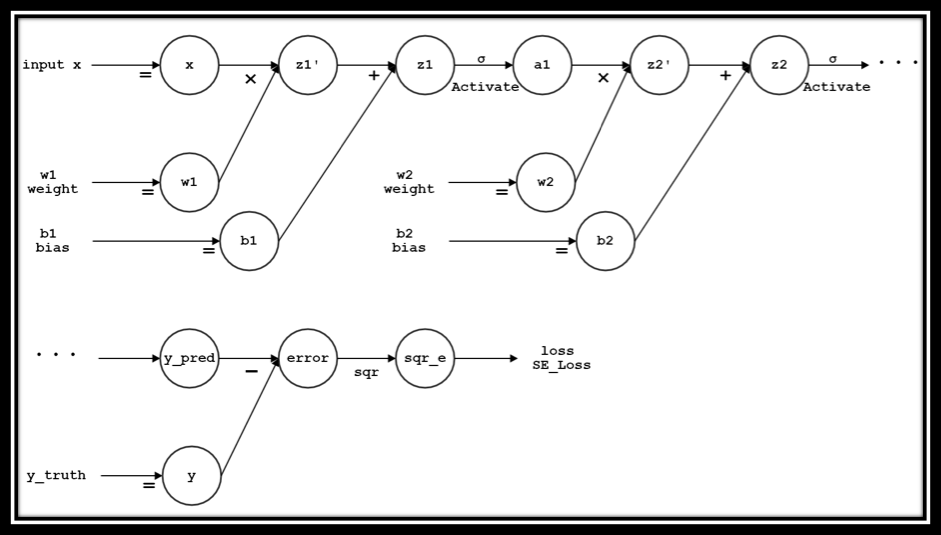

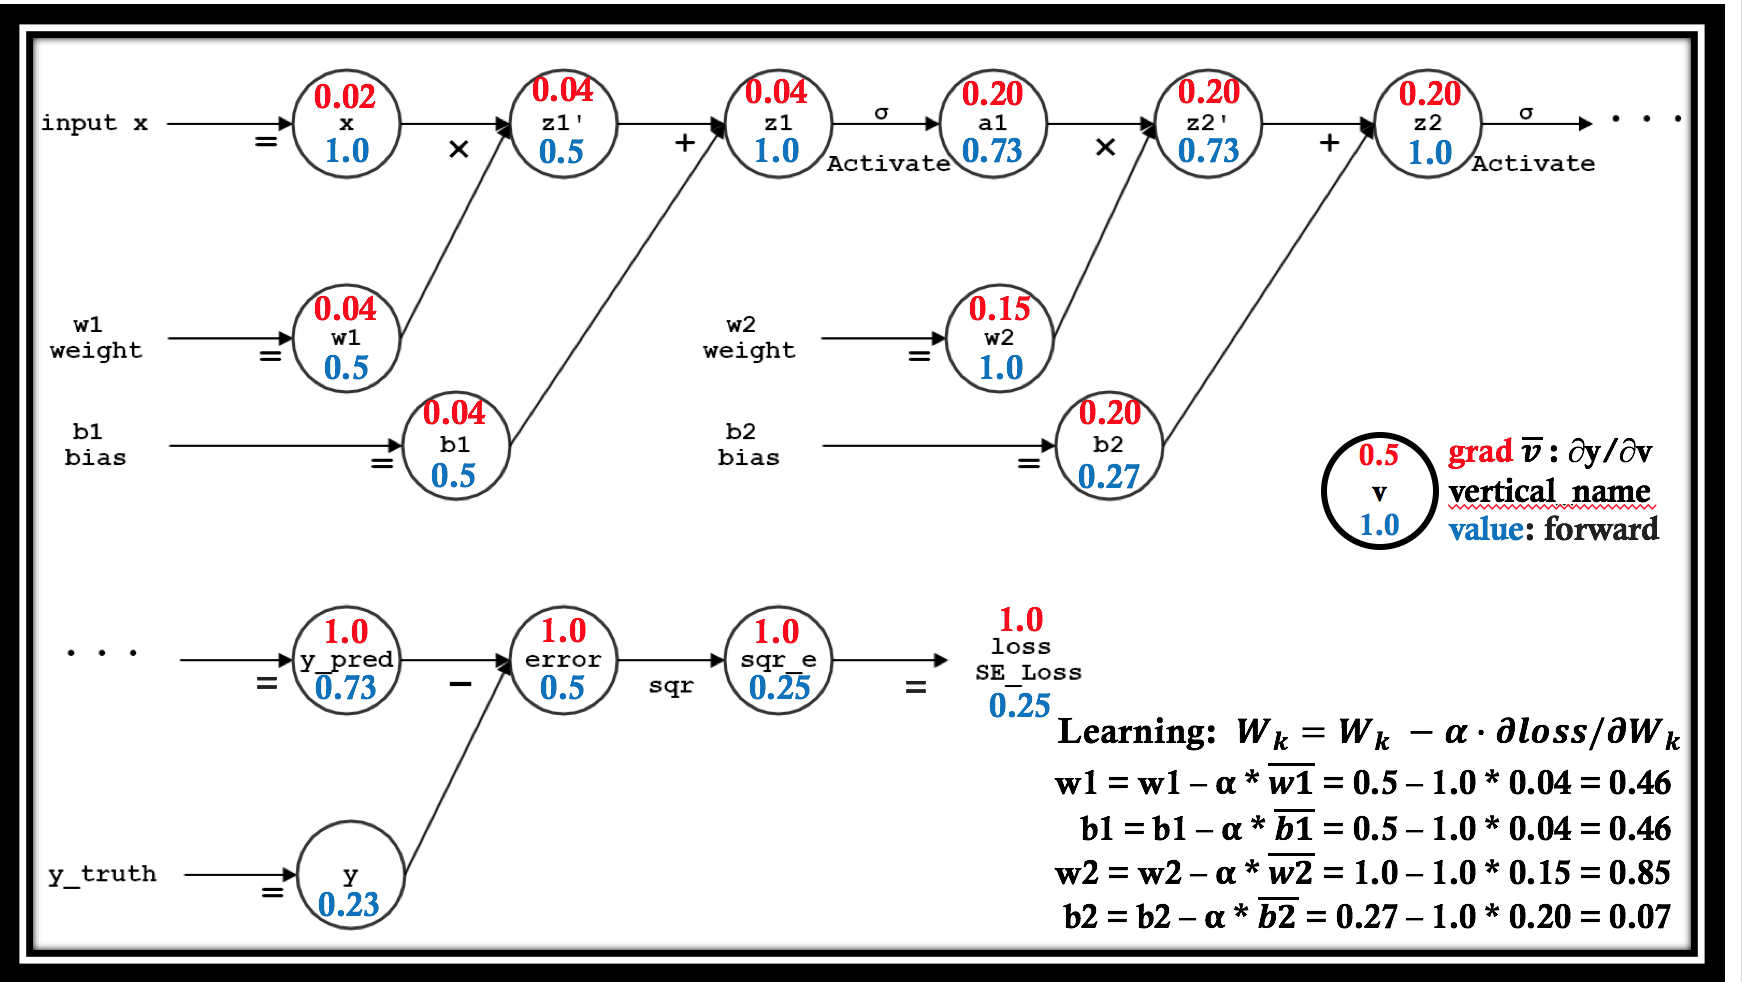

# MNIST


In [2]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("./data", train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("./data", train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=64, shuffle=True)

plt_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("./data", train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=512, shuffle=True)

In [3]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

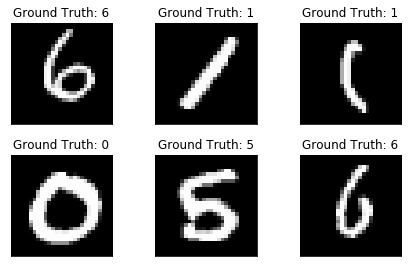

In [4]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap="gray", interpolation="none")
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

## Very simple model: softmax classification

## softmax 公式
$$softmax_i = \frac{e^i}{\sum_{j}e^j}$$ 
softmax直白来说就是将原来输出是3,1,-3通过softmax函数一作用，就映射成为(0,1)的值，而这些值的累和为1（满足概率的性质），那么我们就可以将它理解成概率，在最后选取输出结点的时候，我们就可以选取概率最大（也就是值对应最大的）结点，作为我们的预测目标！

为什么要用softmax呢，soft max两个功能。

## CrossEntropy
$$CrossEntropy = -\sum Y_{i}^{'}log(Y_{i})$$

## one-hot编码
比如一共10个分类，对于分类2的one-hot编码结果就是0 1 0 0 0 0 0 0 0 0，之所以使用one-hot编码的原因，因为神经网络的输出也是一个长度为10的vector，方便进行计算。

## Learning rate
代表每次在梯度上更新的步长，一般来说SGD更依赖learning，对于自适应学习率的优化算法，不需要特别去调learning rate，一般来说1e-3用来调参，1e-4用来产模型。

## mini-batch
+ 加快下降速度，更鲁棒，避免陷入局部最优
+ 每次使用一部分数据进行更新参数，内存的考虑，

In [5]:
def val(model, is_flatten=False):
    model.eval()
    correct = 0
    total = 0
    val_losses = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.cuda(), target.cuda()
            if is_flatten:
                data = data.view(data.size(0), -1)
            outputs = model(data)
            loss = F.nll_loss(outputs, target)
            val_losses.append(loss.data.cpu().numpy())
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 1.0 * correct / total, np.mean(val_losses)

In [6]:
def show_img(data, target):
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.tight_layout()
        plt.imshow(data[i][0], cmap="gray", interpolation="none")
        plt.title("Pred:{}".format(target[i]))
        plt.xticks([])
        plt.yticks([])
        
def miss_img(model, is_flatten=False):
    model.eval()
    correct = 0
    total = 0
    all_data = None
    all_pred = None
    with torch.no_grad():
        for batch_idx, (ori_data, target) in enumerate(plt_loader):
            data, target = ori_data.cuda(), target.cuda()
            if is_flatten:
                data = data.view(data.size(0), -1)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            tmp = ori_data[np.nonzero(predicted != target)].view(np.nonzero(predicted != target).size(0), 1, 28, 28)
            if all_data is None:
                all_data = tmp
            else:
                all_data = torch.cat([all_data, tmp])
            tmp = predicted[np.nonzero(predicted != target)].view((np.nonzero(predicted != target).size(0)))
            if all_pred is None:
                all_pred = tmp
            else:
                all_pred = torch.cat([all_pred, tmp])
    show_img(all_data, all_pred)

In [7]:
def update_lr(optimizer):
    for param_group in optimizer.param_groups:
        param_group["lr"] = param_group["lr"] * 0.95
        
def train(model, optimizer, epoch_num=15, is_flatten=False, show_log=False, lr_decay=False):
    model.train()
    log_interval = 20
    batch_size = 64
    train_losses = []
    test_losses = []
    train_acc_list = []
    acc_list = []
    best_acc = 0.0
    step = 0
    for epoch in range(epoch_num):
        total = 0
        total_correct = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            data, target = data.cuda(), target.cuda()
            if is_flatten:
                data = data.view(data.size(0), -1)
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct = (predicted == target).sum().item()
            total_correct += correct
            train_acc = 1. * correct / data.size(0)
            
            if step % 200 == 0:
                acc, test_loss = val(model, is_flatten)
                best_acc = max(best_acc, acc)
                test_losses.append(test_loss)
                acc_list.append(acc)
                train_acc_list.append(1.0 * total_correct / total)
                train_losses.append(loss)
                total_correct = 0
                total = 0
            if (batch_idx + 1) % (log_interval * 10) == 0 and show_log:
                acc, test_loss = val(model, is_flatten)
                print("Train Epoch: {} [{}/{} ({:.0f}%)]  Loss: {:.6f}  Train Acc: "
                      "{:.4f}  Test Loss: {:.6f}  Test Acc: {:.4f}".format(
                          epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                          100. * (batch_idx + 1) / len(train_loader), loss.item(), train_acc, test_loss, acc))
            
            step += 1
        
        if lr_decay:
            update_lr(optimizer)
            

    plt.plot(train_losses, color="blue", label="train loss")
    plt.plot(test_losses, color="red", label="test loss")
    plt.legend()
    plt.ylabel("train loss")
    plt.show()
    print("Best Accuracy: %f" % best_acc)
    plt.plot(train_acc_list, color="blue", label="train accuracy")
    plt.plot(acc_list, color="red", label="test accuracy")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()
    
    plt.plot(train_losses, color="blue", label="train loss")
    plt.plot(test_losses, color="red", label="test loss")
    plt.legend()
    plt.ylabel("train loss")
    plt.ylim(0.0, 0.2)
    plt.show()
    
    plt.plot(train_acc_list, color="blue", label="train accuracy")
    plt.plot(acc_list, color="red", label="test accuracy")
    plt.ylabel("accuracy")
    plt.legend()
    plt.ylim(0.9, 1.0)
    plt.show()

In [8]:
def run(model, optim="SGD", lr=0.003, epoch_num=25, 
        is_flatten=True, show_log=False, print_weight=None, lr_decay=False):
    model = model().cuda()
    
    if print_weight is not None:
        # 打印weight1梯度
        grad_list = []
        def collect_grad(grad):
            if random.randint(1, 30) == 7:
                grad_list.append(torch.mean(torch.abs(grad[0])).cpu().numpy())
    
        for item in model.named_parameters():
            if item[0] == print_weight:
                h = item[1].register_hook(lambda grad: collect_grad(grad))
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    if optim == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optim == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train(model, optimizer, epoch_num=epoch_num, is_flatten=is_flatten, show_log=show_log, lr_decay=lr_decay)
    
    if print_weight is not None:
        plt.plot(grad_list)
        plt.ylabel(print_weight + " gradient")
        plt.show()

    print("预测错误的图片")
    miss_img(model, is_flatten=True)

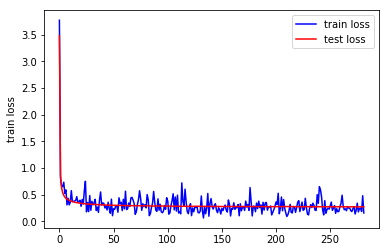

Best Accuracy: 0.923700


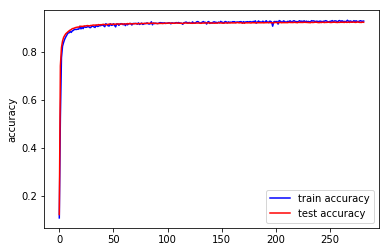

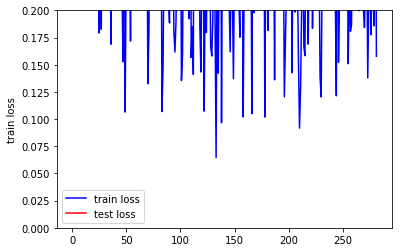

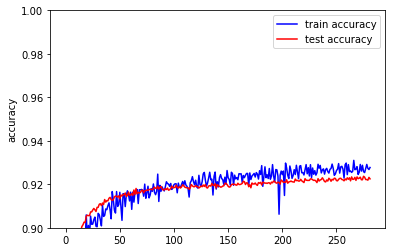

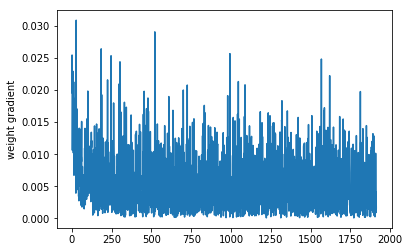

预测错误的图片


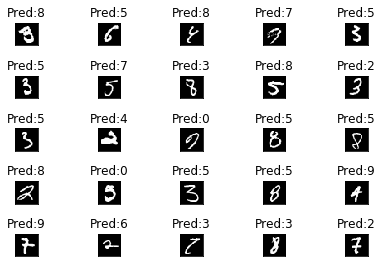

In [9]:
class SingleLayer(nn.Module):
    def __init__(self):
        super(SingleLayer, self).__init__()
        in_features = 784
        out_features = 10
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        self.bias = Parameter(torch.Tensor(out_features))
        self.init_weights(self.weight, self.bias)
    
    def init_weights(self, weight, bias):
        nn.init.uniform_(weight, -0.1, 0.1)
        nn.init.constant_(bias, 0.)
        
    def forward(self, input):
        output = input.matmul(self.weight.t())
        output = output + self.bias
        output = F.log_softmax(output, dim=1)
        return output

run(SingleLayer, optim="SGD", epoch_num=60, lr=0.003, is_flatten=True, show_log=False, print_weight="weight")

# GO DEEP: deeper is better?

## activation function
深度学习的基本原理是基于人工神经网络，信号从一个神经元进入，经过非线性的activation function，传入到下一层神经元；再经过该层神经元的activate，继续往下传递，如此循环往复，直到输出层。
## sigmoid
$$sigmoid(x) = \frac{1}{1+e^{-x}}$$

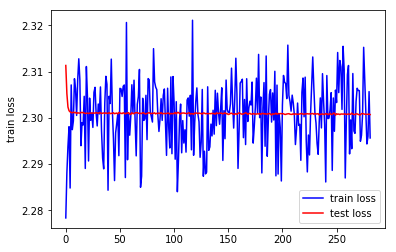

Best Accuracy: 0.113500


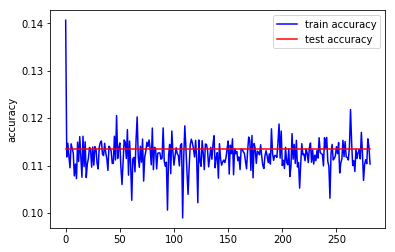

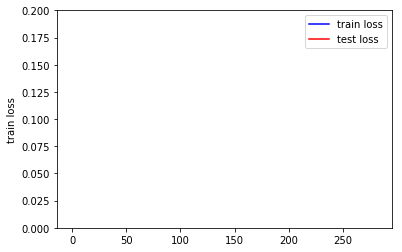

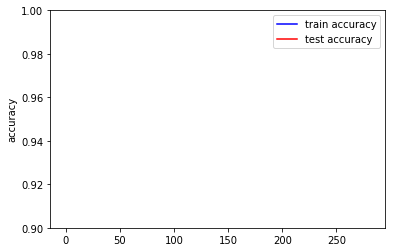

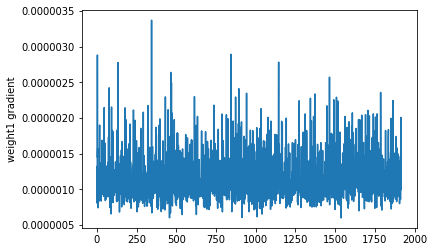

预测错误的图片


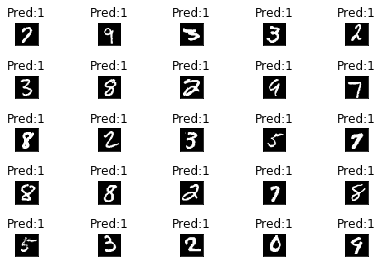

In [10]:
class MultiLayers(nn.Module):
    def __init__(self):
        super(MultiLayers, self).__init__()
        self.weight1 = Parameter(torch.Tensor(200, 784))
        self.bias1 = Parameter(torch.Tensor(200))
        self.init_weights(self.weight1, self.bias1)
        
        self.weight2 = Parameter(torch.Tensor(100, 200))
        self.bias2 = Parameter(torch.Tensor(100))
        self.init_weights(self.weight2, self.bias2)
        
        self.weight3 = Parameter(torch.Tensor(60, 100))
        self.bias3 = Parameter(torch.Tensor(60))
        self.init_weights(self.weight3, self.bias3)
        
        self.weight4 = Parameter(torch.Tensor(30, 60))
        self.bias4 = Parameter(torch.Tensor(30))
        self.init_weights(self.weight4, self.bias4)
        
        self.weight5 = Parameter(torch.Tensor(10, 30))
        self.bias5 = Parameter(torch.Tensor(10))
        self.init_weights(self.weight5, self.bias5)
      
    def init_weights(self, weight, bias):
        nn.init.uniform_(weight, -0.1, 0.1)
        nn.init.constant_(bias, 0.)
        
        
    def forward(self, x):
        x = x.matmul(self.weight1.t()) + self.bias1
        x = torch.sigmoid(x)
        
        x = x.matmul(self.weight2.t()) + self.bias2
        x = torch.sigmoid(x)
        
        x = x.matmul(self.weight3.t()) + self.bias3
        x = torch.sigmoid(x)
        
        x = x.matmul(self.weight4.t()) + self.bias4
        x = torch.sigmoid(x)
        
        x = x.matmul(self.weight5.t()) + self.bias5
        
        x = F.log_softmax(x, dim=1)
        return x
    
run(MultiLayers, optim="SGD", epoch_num=60, lr=0.003, is_flatten=True, show_log=False, print_weight="weight1")

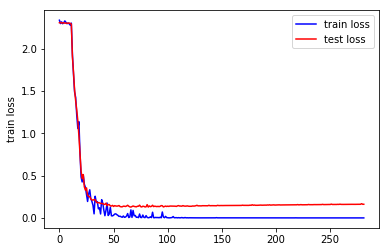

Best Accuracy: 0.972300


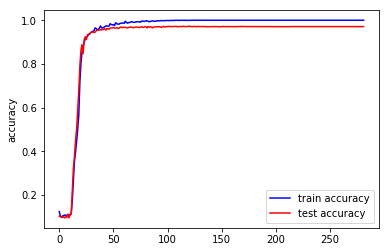

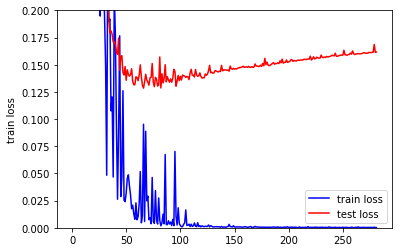

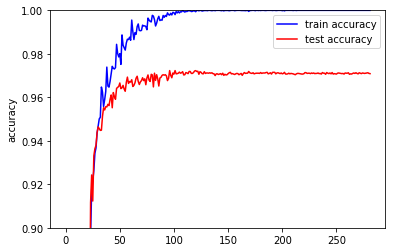

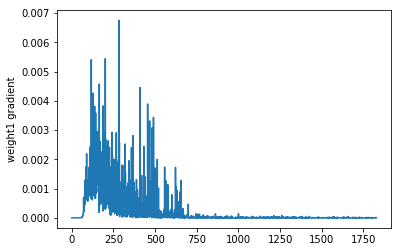

预测错误的图片


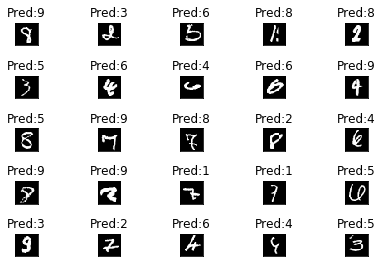

In [11]:
# sigmoid with big learning rate
class MultiLayers(nn.Module):
    def __init__(self):
        super(MultiLayers, self).__init__()
        self.weight1 = Parameter(torch.Tensor(200, 784))
        self.bias1 = Parameter(torch.Tensor(200))
        self.init_weights(self.weight1, self.bias1)
        
        self.weight2 = Parameter(torch.Tensor(100, 200))
        self.bias2 = Parameter(torch.Tensor(100))
        self.init_weights(self.weight2, self.bias2)
        
        self.weight3 = Parameter(torch.Tensor(60, 100))
        self.bias3 = Parameter(torch.Tensor(60))
        self.init_weights(self.weight3, self.bias3)
        
        self.weight4 = Parameter(torch.Tensor(30, 60))
        self.bias4 = Parameter(torch.Tensor(30))
        self.init_weights(self.weight4, self.bias4)
        
        self.weight5 = Parameter(torch.Tensor(10, 30))
        self.bias5 = Parameter(torch.Tensor(10))
        self.init_weights(self.weight5, self.bias5)
      
    def init_weights(self, weight, bias):
        nn.init.uniform_(weight, -0.1, 0.1)
        nn.init.constant_(bias, 0.)
        
        
    def forward(self, x):
        x = x.matmul(self.weight1.t()) + self.bias1
        x = torch.sigmoid(x)
        
        x = x.matmul(self.weight2.t()) + self.bias2
        x = torch.sigmoid(x)
        
        x = x.matmul(self.weight3.t()) + self.bias3
        x = torch.sigmoid(x)
        
        x = x.matmul(self.weight4.t()) + self.bias4
        x = torch.sigmoid(x)
        
        x = x.matmul(self.weight5.t()) + self.bias5
        
        x = F.log_softmax(x, dim=1)
        return x
    
run(MultiLayers, optim="SGD", epoch_num=60, lr=0.3, is_flatten=True, show_log=False, print_weight="weight1")

# 初始化is matter
## 结论
对于ReLU，建议使用he Initialization。
## Xavier && He initialization:
一般情况下是用随机初始化：都初始化为0肯定是不行的，因为这样所有的神经元的输出是一样的，反向传播的时候梯度都是一样的，更新参数也是一样的。但是随机初始化如果随机不当也会有问题，比如随机的值都非常小，注意到反向传播中链式求导法则里面， 后面层的梯度等于前面层梯度乘以当前层梯度，如果参数很小的话，越后面的层梯度就越小，参数难以更新。
初始化的基本原理是说尽量保证输入和输出的方差一致，避免了输出值趋向于0，`W = np.random.randn(node_in, node_out) / np.sqrt(node_in/2)`，除以2是因为对于同一层的神经元，relu大概一半激活，一半不激活。

In [12]:
data = torch.randn(2000, 800)
layer_sizes = [800 - 50 * i for i in range(0, 10)]
num_layers = len(layer_sizes)

print('input mean {0:.5f} and std {1:.5f}'.format(np.mean(data.cpu().numpy()), np.std(data.cpu().numpy())))

def fc_layer(init_weight=None, use_bn=False, activation="relu"):
    fcs = []
    for i in range(0, num_layers - 1):
        X = data if i == 0 else fcs[i - 1]
        node_in = layer_sizes[i]
        node_out = layer_sizes[i + 1]
        W = torch.randn(node_in, node_out) * 0.01
        if init_weight == "he":
            W = torch.randn(node_in, node_out) / np.sqrt(node_in / 2)
        elif init_weight == "xavier":
            W = torch.randn(node_in, node_out) / np.sqrt(node_in)
        fc = torch.matmul(X, W)
        if use_bn:
            m = torch.mean(fc, 0)
            v = torch.var(fc, 0)
            fc = F.batch_norm(fc, running_mean=m, running_var=v)
        if activation == "relu":
            fc = F.relu(fc)
        elif activation == "tanh":
            fc = torch.tanh(fc)
        fcs.append(fc)
    return fcs

input mean -0.00025 and std 1.00074


layer 1 mean 0.11271 and std 0.16504
layer 2 mean 0.02232 and std 0.03233
layer 3 mean 0.00429 and std 0.00638
layer 4 mean 0.00076 and std 0.00113
layer 5 mean 0.00014 and std 0.00020
layer 6 mean 0.00002 and std 0.00004
layer 7 mean 0.00000 and std 0.00001
layer 8 mean 0.00000 and std 0.00000
layer 9 mean 0.00000 and std 0.00000


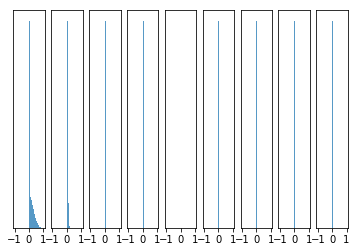

In [13]:
fcs = fc_layer(init_weight=None, use_bn=False)
for idx, fc in enumerate(fcs):
    print('layer {0} mean {1:.5f} and std {2:.5f}'.format(idx+1, np.mean(fc.cpu().numpy()), np.std(fc.cpu().numpy())))

plt.figure()
for idx, fc in enumerate(fcs):
    plt.subplot(1, len(fcs), idx+1)
    plt.yticks([])
    plt.hist(fc.cpu().numpy().flatten(), 30, range=[-1,1], alpha=0.75)

layer 1 mean 0.39728 and std 0.58293
layer 2 mean 0.27896 and std 0.41128
layer 3 mean 0.18348 and std 0.27778
layer 4 mean 0.13568 and std 0.19824
layer 5 mean 0.09747 and std 0.14386
layer 6 mean 0.06676 and std 0.10010
layer 7 mean 0.04609 and std 0.06776
layer 8 mean 0.03061 and std 0.04620
layer 9 mean 0.02251 and std 0.03283


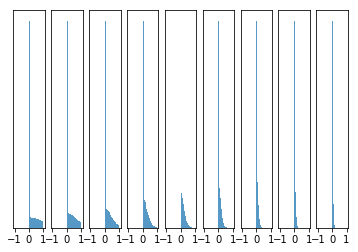

In [14]:
fcs = fc_layer(init_weight="xavier", use_bn=False)
for idx, fc in enumerate(fcs):
    print('layer {0} mean {1:.5f} and std {2:.5f}'.format(idx+1, np.mean(fc.cpu().numpy()), np.std(fc.cpu().numpy())))

plt.figure()
for idx, fc in enumerate(fcs):
    plt.subplot(1, len(fcs), idx+1)
    plt.yticks([])
    plt.hist(fc.cpu().numpy().flatten(), 30, range=[-1,1], alpha=0.75)

layer 1 mean -0.00056 and std 0.62787
layer 2 mean 0.00037 and std 0.48649
layer 3 mean -0.00043 and std 0.40817
layer 4 mean 0.00005 and std 0.35872
layer 5 mean 0.00012 and std 0.32277
layer 6 mean 0.00044 and std 0.29526
layer 7 mean 0.00025 and std 0.27378
layer 8 mean -0.00004 and std 0.25561
layer 9 mean -0.00041 and std 0.24018


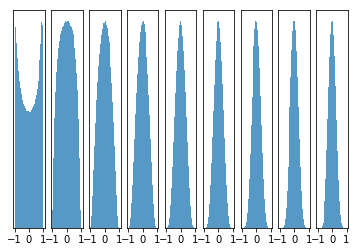

In [15]:
fcs = fc_layer(init_weight="xavier", use_bn=False, activation="relu")
for idx, fc in enumerate(fcs):
    print('layer {0} mean {1:.5f} and std {2:.5f}'.format(idx+1, np.mean(fc.cpu().numpy()), np.std(fc.cpu().numpy())))

plt.figure()
for idx, fc in enumerate(fcs):
    plt.subplot(1, len(fcs), idx+1)
    plt.yticks([])
    plt.hist(fc.cpu().numpy().flatten(), 30, range=[-1,1], alpha=0.75)

layer 1 mean 0.56419 and std 0.82637
layer 2 mean 0.55424 and std 0.81282
layer 3 mean 0.53597 and std 0.80791
layer 4 mean 0.52899 and std 0.77497
layer 5 mean 0.53381 and std 0.79168
layer 6 mean 0.55273 and std 0.78742
layer 7 mean 0.51263 and std 0.76579
layer 8 mean 0.54302 and std 0.78707
layer 9 mean 0.47723 and std 0.72327


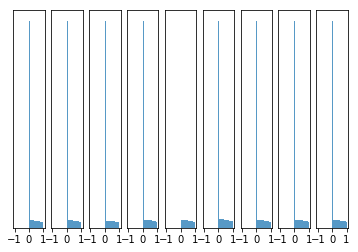

In [16]:
fcs = fc_layer(init_weight="he", use_bn=False)
for idx, fc in enumerate(fcs):
    print('layer {0} mean {1:.5f} and std {2:.5f}'.format(idx+1, np.mean(fc.cpu().numpy()), np.std(fc.cpu().numpy())))

plt.figure()
for idx, fc in enumerate(fcs):
    plt.subplot(1, len(fcs), idx+1)
    plt.yticks([])
    plt.hist(fc.cpu().numpy().flatten(), 30, range=[-1,1], alpha=0.75)

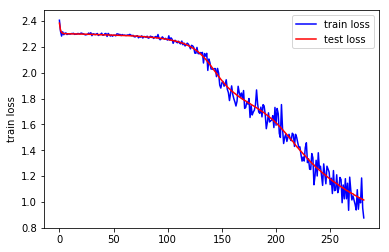

Best Accuracy: 0.704400


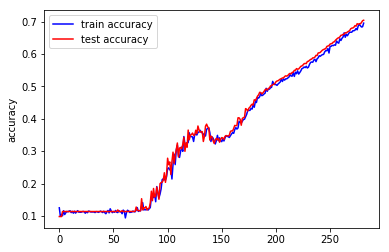

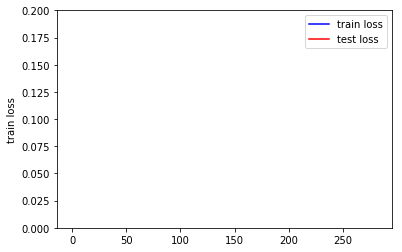

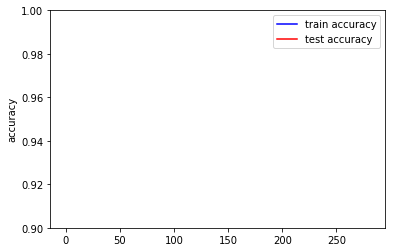

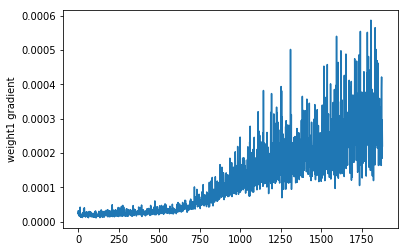

预测错误的图片


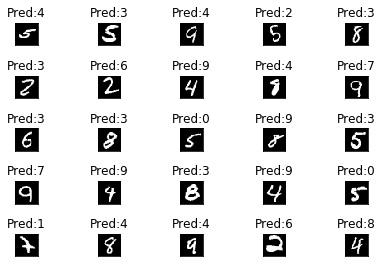

In [17]:
# sigmoid with xavier initialize
class MultiLayers(nn.Module):
    def __init__(self):
        super(MultiLayers, self).__init__()
        self.weight1 = Parameter(torch.Tensor(200, 784))
        self.bias1 = Parameter(torch.Tensor(200))
        self.init_weights(self.weight1, self.bias1)
        
        self.weight2 = Parameter(torch.Tensor(100, 200))
        self.bias2 = Parameter(torch.Tensor(100))
        self.init_weights(self.weight2, self.bias2)
        
        self.weight3 = Parameter(torch.Tensor(60, 100))
        self.bias3 = Parameter(torch.Tensor(60))
        self.init_weights(self.weight3, self.bias3)
        
        self.weight4 = Parameter(torch.Tensor(30, 60))
        self.bias4 = Parameter(torch.Tensor(30))
        self.init_weights(self.weight4, self.bias4)
        
        self.weight5 = Parameter(torch.Tensor(10, 30))
        self.bias5 = Parameter(torch.Tensor(10))
        self.init_weights(self.weight5, self.bias5)
      
    def init_weights(self, weight, bias):
        nn.init.xavier_normal_(weight)
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(bias, -bound, bound)
        
        
    def forward(self, x):
        x = x.matmul(self.weight1.t()) + self.bias1
        x = torch.sigmoid(x)
        
        x = x.matmul(self.weight2.t()) + self.bias2
        x = torch.sigmoid(x)
        
        x = x.matmul(self.weight3.t()) + self.bias3
        x = torch.sigmoid(x)
        
        x = x.matmul(self.weight4.t()) + self.bias4
        x = torch.sigmoid(x)
        
        x = x.matmul(self.weight5.t()) + self.bias5
        
        x = F.log_softmax(x, dim=1)
        return x
    
run(MultiLayers, optim="SGD", epoch_num=60, lr=0.003, is_flatten=True, show_log=False, print_weight="weight1")

# Activation function (激活函数)
## Best Practice
优先使用ReLU，`ReLU = max(0, x)`，配合kaiming he初始化，batch norm使用
## sigmoid
$$sigmoid(x) = \frac{1}{1+e^{-x}}$$
Sigmoid函数是深度学习领域开始时使用频率最高的activation function。它是便于求导的平滑函数，其导数为$\sigma(x)(1 - \sigma(x))$，这是优点。然而，Sigmoid有三大缺点：
+ **容易出现gradient vanishing**: 优化神经网络的方法是Back Propagation，即导数的后向传递：先计算输出层对应的loss，然后将loss以导数的形式不断向上一层网络传递，修正相应的参数，达到降低loss的目的。 Sigmoid函数在深度网络中常常会导致导数逐渐变为0，使得参数无法被更新，神经网络无法被优化。原因在于两点：(1) 在上图中容易看出，当\sigma(x)中x较大或较小时，导数接近0，而后向传递的数学依据是微积分求导的链式法则，当前层的导数需要之前各层导数的乘积，几个小数的相乘，结果会很接近0 (2) Sigmoid导数的最大值是0.25，这意味着导数在每一层至少会被压缩为原来的1/4，通过两层后被变为1/16，…，通过10层后为1/1048576。请注意这里是“至少”，导数达到最大值这种情况还是很少见的。
+ **函数输出并不是zero-centered**: Sigmoid函数的输出值恒大于0，这会导致模型训练的收敛速度变慢。举例来讲，对$\sigma(\sum_i w_i x_i + b)$，如果所有$x_i$均为正数或负数，那么其对$w_i$的导数总是正数或负数，这会导致如下图红色箭头所示的阶梯式更新，这显然并非一个好的优化路径。深度学习往往需要大量时间来处理大量数据，模型的收敛速度是尤为重要的。所以，总体上来讲，训练深度学习网络尽量使用zero-centered数据 (可以经过数据预处理实现) 和zero-centered输出。
+ **幂运算相对来讲比较耗时**

In [19]:
def plot_activation(act, label):
    x = np.arange(-8, 8, 0.1)
    plt.plot(x, act(x), label=label)
    plt.legend()

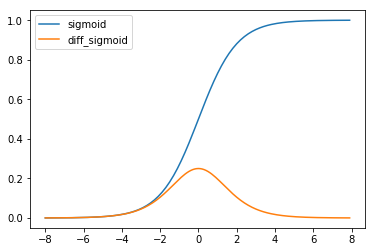

In [20]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def diff_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))
plot_activation(sigmoid, "sigmoid")
plot_activation(diff_sigmoid, "diff_sigmoid")

## tanh
$$tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$
解决了zero-centered问题，但是gradient vanishing和运算复杂问题仍然解决不了

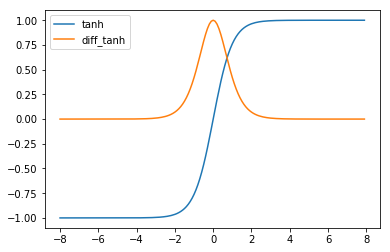

In [21]:
def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
def diff_tanh(x):
    return 1 - tanh(x) * tanh(x)
plot_activation(tanh, "tanh")
plot_activation(diff_tanh, "diff_tanh")

## ReLU
$$ReLU(x) = max(0, x)$$

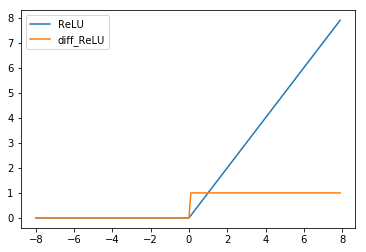

In [22]:
def ReLU(x):
    return np.maximum(x, 0)
def diff_ReLU(x):
    return 1. * (x > 0)
plot_activation(ReLU, "ReLU")
plot_activation(diff_ReLU, "diff_ReLU")

ReLU函数其实就是一个取最大值函数，注意这并不是全区间可导的，但是我们可以取sub-gradient，如上图所示。ReLU虽然简单，但却是近几年的重要成果，有以下几大优点：
+ 解决了gradient vanishing问题 (在正区间)
+ 计算速度非常快，只需要判断输入是否大于0
+ 收敛速度远快于sigmoid和tanh

ReLU也有几个需要特别注意的问题：
+ ReLU的输出不是zero-centered
+ Dead ReLU Problem，指的是某些神经元可能永远不会被激活，导致相应的参数永远不能被更新。有两个主要原因可能导致这种情况产生: (1) 非常不幸的参数初始化，这种情况比较少见 (2) learning rate太高导致在训练过程中参数更新太大，不幸使网络进入这种状态。解决方法是可以采用Kaiming He初始化方法，以及避免将learning rate设置太大或使用adagrad等自动调节learning rate的算法。

## LeakyReLU
$$LeakyReLU(x) = max(0.01x, x)$$

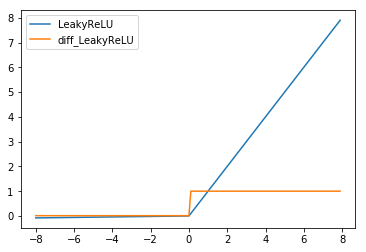

In [23]:
def LeakyReLU(x):
    return np.maximum(x, 0.01 * x)
def diff_LeakyReLU(x):
    return 0.99 * (x > 0) + 0.01
plot_activation(LeakyReLU, "LeakyReLU")
plot_activation(diff_LeakyReLU, "diff_LeakyReLU")

为了解决Dead ReLU Problem，提出了将ReLU的前半段设为0.01x而非0。另外一种直观的想法是基于参数的方法，即Parametric ReLU:$f(x) = \max(\alpha x, x)$，其中$\alpha$
可由back propagation学出来。理论上来讲，Leaky ReLU有ReLU的所有优点，外加不会有Dead ReLU问题，但是在实际操作当中，并没有完全证明Leaky ReLU总是好于ReLU。

## other activation function
+ ELU
+ ...

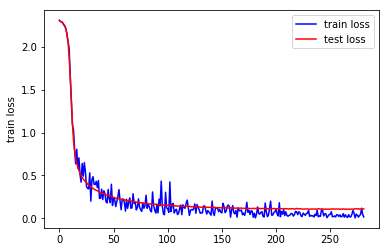

Best Accuracy: 0.971300


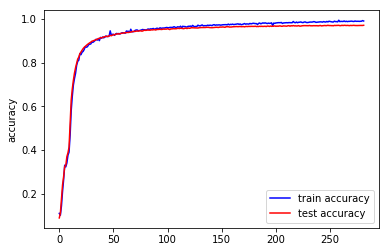

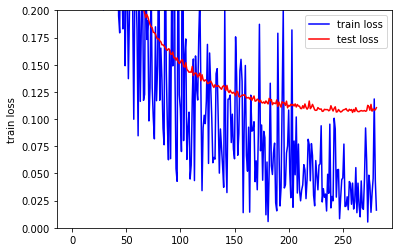

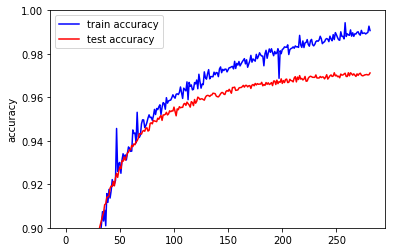

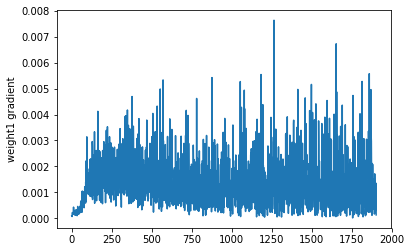

预测错误的图片


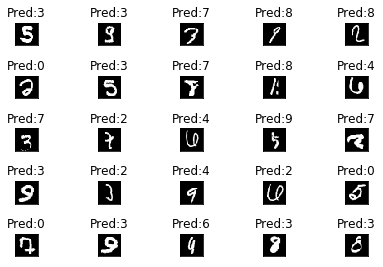

In [24]:
# relu + small learning rate
class MultiLayers(nn.Module):
    def __init__(self):
        super(MultiLayers, self).__init__()
        self.weight1 = Parameter(torch.Tensor(200, 784))
        self.bias1 = Parameter(torch.Tensor(200))
        self.init_weights(self.weight1, self.bias1)
        
        self.weight2 = Parameter(torch.Tensor(100, 200))
        self.bias2 = Parameter(torch.Tensor(100))
        self.init_weights(self.weight2, self.bias2)
        
        self.weight3 = Parameter(torch.Tensor(60, 100))
        self.bias3 = Parameter(torch.Tensor(60))
        self.init_weights(self.weight3, self.bias3)
        
        self.weight4 = Parameter(torch.Tensor(30, 60))
        self.bias4 = Parameter(torch.Tensor(30))
        self.init_weights(self.weight4, self.bias4)
        
        self.weight5 = Parameter(torch.Tensor(10, 30))
        self.bias5 = Parameter(torch.Tensor(10))
        self.init_weights(self.weight5, self.bias5)
      
    def init_weights(self, weight, bias):
        nn.init.uniform_(weight, -0.1, 0.1)
        # small bias can not be zero
        nn.init.constant_(bias, 0.1)
        
        
    def forward(self, x):
        x = x.matmul(self.weight1.t()) + self.bias1
        x = F.relu(x)
        
        x = x.matmul(self.weight2.t()) + self.bias2
        x = F.relu(x)
        
        x = x.matmul(self.weight3.t()) + self.bias3
        x = F.relu(x)
        
        x = x.matmul(self.weight4.t()) + self.bias4
        x = F.relu(x)
        
        x = x.matmul(self.weight5.t()) + self.bias5
        
        x = F.log_softmax(x, dim=1)
        return x
    
run(MultiLayers, optim="SGD", epoch_num=60, lr=0.003, is_flatten=True, show_log=False, print_weight="weight1")

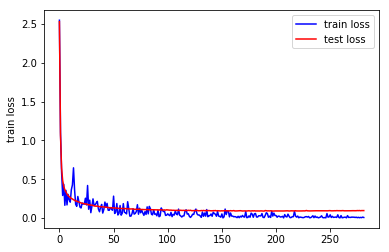

Best Accuracy: 0.975000


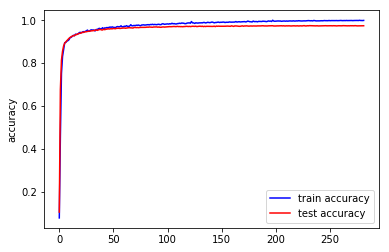

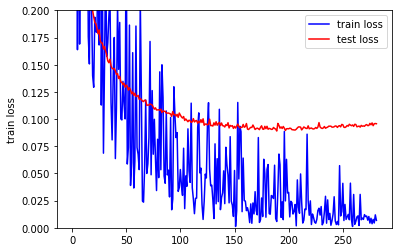

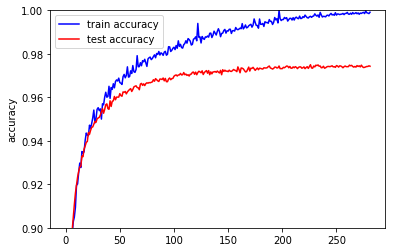

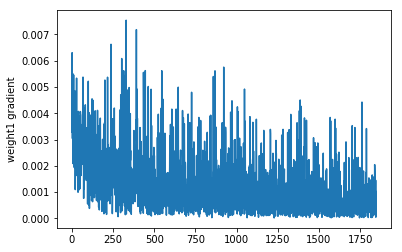

预测错误的图片


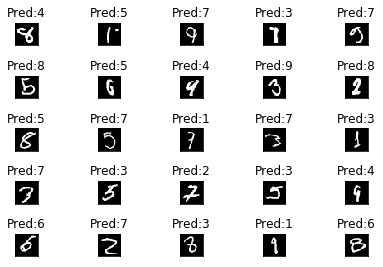

In [25]:
# relu + small learning rate + kaiming he initialize
class MultiLayers(nn.Module):
    def __init__(self):
        super(MultiLayers, self).__init__()
        self.weight1 = Parameter(torch.Tensor(200, 784))
        self.bias1 = Parameter(torch.Tensor(200))
        self.init_weights(self.weight1, self.bias1)
        
        self.weight2 = Parameter(torch.Tensor(100, 200))
        self.bias2 = Parameter(torch.Tensor(100))
        self.init_weights(self.weight2, self.bias2)
        
        self.weight3 = Parameter(torch.Tensor(60, 100))
        self.bias3 = Parameter(torch.Tensor(60))
        self.init_weights(self.weight3, self.bias3)
        
        self.weight4 = Parameter(torch.Tensor(30, 60))
        self.bias4 = Parameter(torch.Tensor(30))
        self.init_weights(self.weight4, self.bias4)
        
        self.weight5 = Parameter(torch.Tensor(10, 30))
        self.bias5 = Parameter(torch.Tensor(10))
        self.init_weights(self.weight5, self.bias5)
      
    def init_weights(self, weight, bias):
        nn.init.kaiming_uniform_(weight)
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(bias, -bound, bound)
        
        
    def forward(self, x):
        x = x.matmul(self.weight1.t()) + self.bias1
        x = F.relu(x)
        
        x = x.matmul(self.weight2.t()) + self.bias2
        x = F.relu(x)
        
        x = x.matmul(self.weight3.t()) + self.bias3
        x = F.relu(x)
        
        x = x.matmul(self.weight4.t()) + self.bias4
        x = F.relu(x)
        
        x = x.matmul(self.weight5.t()) + self.bias5
        
        x = F.log_softmax(x, dim=1)
        return x
    
run(MultiLayers, optim="SGD", epoch_num=60, lr=0.003, is_flatten=True, show_log=False, print_weight="weight1")

## 优化算法
实际bp过程的时候计算出梯度后，进行更新参数的时候，会用到优化算法，比如sgd，adam等。
### 参考文献
[一个框架看懂优化算法之异同 SGD/AdaGrad/Adam](https://zhuanlan.zhihu.com/p/32230623)
### 结论
首先定义：待优化参数： w ，目标函数： f(w) ，初始学习率 $\alpha$。

而后，开始进行迭代优化。在每个epoch t ：

+ 计算目标函数关于当前参数的梯度： $g_t=\nabla f(w_t)$
+ 根据历史梯度计算一阶动量和二阶动量：$m_t = \phi(g_1, g_2, \cdots, g_t)$; $V_t = \psi(g_1, g_2, \cdots, g_t)$，
+ 计算当前时刻的下降梯度： $\eta_t = \frac{\alpha \cdot m_t}{\sqrt{V_t}}$
+ 根据下降梯度进行更新： $w_{t+1} = w_t - \eta_t$

### SGD
先来看SGD。SGD没有动量的概念，也就是说：

$m_t = g_t$; $V_t = I^2$

代入步骤3，可以看到下降梯度就是最简单的

$\eta_t = \alpha \cdot g_t$ 

SGD最大的缺点是下降速度慢，而且可能会在沟壑的两边持续震荡，停留在一个局部最优点，另外当训练轮数变长的时候，需要去更新学习率，避免步长过长导致每次更新就越过最优点。

### SGD with Momentum
为了抑制SGD的震荡，SGDM认为梯度下降过程可以加入惯性。下坡的时候，如果发现是陡坡，那就利用惯性跑的快一些。SGDM全称是SGD with momentum，在SGD基础上引入了一阶动量：

$m_t = \beta_1 \cdot m_{t-1} + (1-\beta_1)\cdot g_t$

一阶动量是各个时刻梯度方向的指数移动平均值，约等于最近 $1/(1-\beta_1)$ 个时刻的梯度向量和的平均值。

也就是说，t时刻的下降方向，不仅由当前点的梯度方向决定，而且由此前累积的下降方向决定。 $\beta_1$ 的经验值为0.9，这就意味着下降方向主要是此前累积的下降方向，并略微偏向当前时刻的下降方向。想象高速公路上汽车转弯，在高速向前的同时略微偏向，急转弯可是要出事的。

### SGD with Nesterov Acceleration
SGD 还有一个问题是困在局部最优的沟壑里面震荡。想象一下你走到一个盆地，四周都是略高的小山，你觉得没有下坡的方向，那就只能待在这里了。可是如果你爬上高地，就会发现外面的世界还很广阔。因此，我们不能停留在当前位置去观察未来的方向，而要向前一步、多看一步、看远一些。

NAG全称Nesterov Accelerated Gradient，是在SGD、SGD-M的基础上的进一步改进，改进点在于步骤1。我们知道在时刻t的主要下降方向是由累积动量决定的，自己的梯度方向说了也不算，那与其看当前梯度方向，不如先看看如果跟着累积动量走了一步，那个时候再怎么走。因此，NAG在步骤1，不计算当前位置的梯度方向，而是计算如果按照累积动量走了一步，那个时候的下降方向：

$g_t=\nabla f(w_t-\alpha \cdot m_{t-1} / \sqrt{V_{t-1}})$

然后用下一个点的梯度方向，与历史累积动量相结合，计算步骤2中当前时刻的累积动量。

### AdaGrad
此前我们都没有用到二阶动量。二阶动量的出现，才意味着“自适应学习率”优化算法时代的到来。SGD及其变种以同样的学习率更新每个参数，但深度神经网络往往包含大量的参数，这些参数并不是总会用得到（想想大规模的embedding）。对于经常更新的参数，我们已经积累了大量关于它的知识，不希望被单个样本影响太大，希望学习速率慢一些；对于偶尔更新的参数，我们了解的信息太少，希望能从每个偶然出现的样本身上多学一些，即学习速率大一些。

怎么样去度量历史更新频率呢？那就是二阶动量——该维度上，迄今为止所有梯度值的平方和：

$V_t = \sum_{\tau=1}^{t} g_\tau^2$

我们再回顾一下步骤3中的下降梯度：

$\eta_t = \alpha \cdot m_t / \sqrt{V_t}$

可以看出，此时实质上的学习率由  $\alpha$ 变成了  $\alpha / \sqrt{V_t}$ 。 一般为了避免分母为0，会在分母上加一个小的平滑项。因此$\sqrt{V_t}$ 是恒大于0的，而且参数更新越频繁，二阶动量越大，学习率就越小。

这一方法在稀疏数据场景下表现非常好。但也存在一些问题：因为$\sqrt{V_t}$是单调递增的，会使得学习率单调递减至0，可能会使得训练过程提前结束，即便后续还有数据也无法学到必要的知识。

### AdaDelta / RMSProp
由于AdaGrad单调递减的学习率变化过于激进，我们考虑一个改变二阶动量计算方法的策略：不累积全部历史梯度，而只关注过去一段时间窗口的下降梯度。这也就是AdaDelta名称中Delta的来历。

修改的思路很简单。前面我们讲到，指数移动平均值大约就是过去一段时间的平均值，因此我们用这一方法来计算二阶累积动量：

$V_t = \beta_2 * V_{t-1} + (1-\beta_2) g_t^2$

这就避免了二阶动量持续累积、导致训练过程提前结束的问题了。

### Adam
谈到这里，Adam和Nadam的出现就很自然而然了——它们是前述方法的集大成者。我们看到，SGD-M在SGD基础上增加了一阶动量，AdaGrad和AdaDelta在SGD基础上增加了二阶动量。把一阶动量和二阶动量都用起来，就是Adam了——Adaptive + Momentum。

SGD的一阶动量：

$m_t = \beta_1 \cdot m_{t-1} + (1-\beta_1)\cdot g_t$

加上AdaDelta的二阶动量：

$V_t = \beta_2 * V_{t-1} + (1-\beta_2) g_t^2$

优化算法里最常见的两个超参数  $\beta_1$, $\beta_2$ 就都在这里了，前者控制一阶动量，后者控制二阶动量。

### Nadam

最后是Nadam。我们说Adam是集大成者，但它居然遗漏了Nesterov，这还能忍？必须给它加上，按照NAG的步骤1：

$g_t=\nabla f(w_t-\alpha \cdot m_{t-1} / \sqrt{V_t})$


这就是Nesterov + Adam = Nadam了。


### 扩展阅读
+ [Adam那么棒，为什么还对SGD念念不忘 (2)—— Adam的两宗罪](https://zhuanlan.zhihu.com/p/32262540)
+ [Adam那么棒，为什么还对SGD念念不忘 (3)—— 优化算法的选择与使用策略](https://zhuanlan.zhihu.com/p/32338983)
+ [都9102年了，别再用Adam + L2 regularization了](https://zhuanlan.zhihu.com/p/63982470)

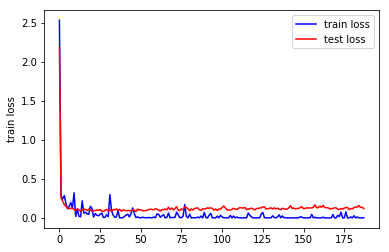

Best Accuracy: 0.982900


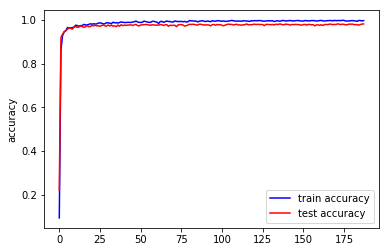

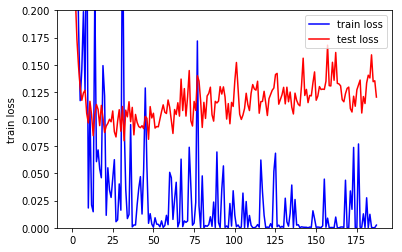

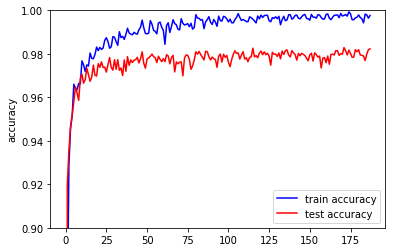

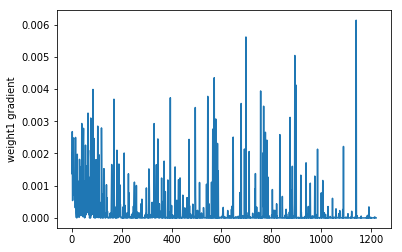

预测错误的图片


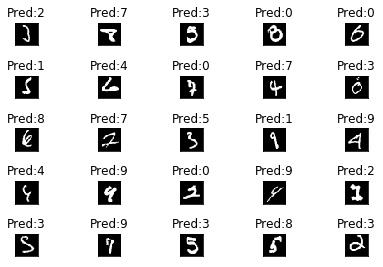

In [26]:
# relu + small learning rate + kaiming he initialize + adam
class MultiLayers(nn.Module):
    def __init__(self):
        super(MultiLayers, self).__init__()
        self.weight1 = Parameter(torch.Tensor(200, 784))
        self.bias1 = Parameter(torch.Tensor(200))
        self.init_weights(self.weight1, self.bias1)
        
        self.weight2 = Parameter(torch.Tensor(100, 200))
        self.bias2 = Parameter(torch.Tensor(100))
        self.init_weights(self.weight2, self.bias2)
        
        self.weight3 = Parameter(torch.Tensor(60, 100))
        self.bias3 = Parameter(torch.Tensor(60))
        self.init_weights(self.weight3, self.bias3)
        
        self.weight4 = Parameter(torch.Tensor(30, 60))
        self.bias4 = Parameter(torch.Tensor(30))
        self.init_weights(self.weight4, self.bias4)
        
        self.weight5 = Parameter(torch.Tensor(10, 30))
        self.bias5 = Parameter(torch.Tensor(10))
        self.init_weights(self.weight5, self.bias5)
      
    def init_weights(self, weight, bias):
        nn.init.kaiming_uniform_(weight)
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(bias, -bound, bound)
        
        
    def forward(self, x):
        x = x.matmul(self.weight1.t()) + self.bias1
        x = F.relu(x)
        
        x = x.matmul(self.weight2.t()) + self.bias2
        x = F.relu(x)
        
        x = x.matmul(self.weight3.t()) + self.bias3
        x = F.relu(x)
        
        x = x.matmul(self.weight4.t()) + self.bias4
        x = F.relu(x)
        
        x = x.matmul(self.weight5.t()) + self.bias5
        
        x = F.log_softmax(x, dim=1)
        return x
    
run(MultiLayers, optim="Adam", epoch_num=40, lr=0.001, is_flatten=True, show_log=False, print_weight="weight1")

## Dropout
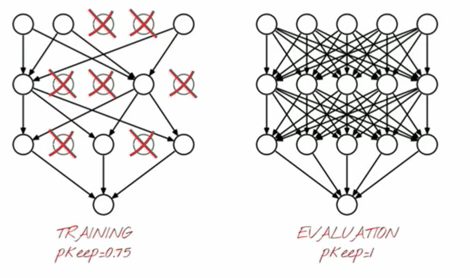

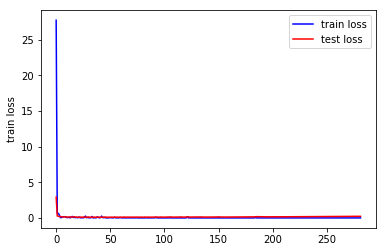

Best Accuracy: 0.983700


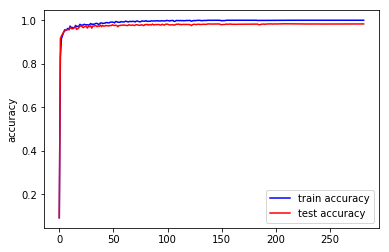

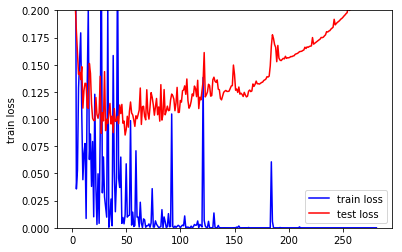

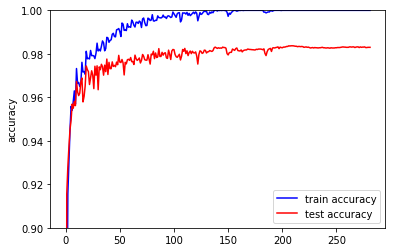

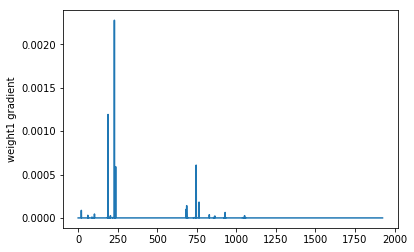

预测错误的图片


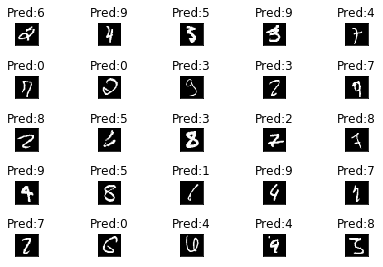

In [27]:
# relu + small learning rate + kaiming he initialize + adam
class MultiLayers(nn.Module):
    def __init__(self):
        super(MultiLayers, self).__init__()
        self.weight1 = Parameter(torch.Tensor(200, 784))
        self.bias1 = Parameter(torch.Tensor(200))
        self.drop1 = nn.Dropout(0.75)
        self.init_weights(self.weight1, self.bias1)
        
        self.weight2 = Parameter(torch.Tensor(100, 200))
        self.bias2 = Parameter(torch.Tensor(100))
        self.drop2 = nn.Dropout(0.75)
        self.init_weights(self.weight2, self.bias2)
        
        self.weight3 = Parameter(torch.Tensor(60, 100))
        self.bias3 = Parameter(torch.Tensor(60))
        self.drop3 = nn.Dropout(0.75)
        self.init_weights(self.weight3, self.bias3)
        
        self.weight4 = Parameter(torch.Tensor(30, 60))
        self.bias4 = Parameter(torch.Tensor(30))
        self.drop4 = nn.Dropout(0.75)
        self.init_weights(self.weight4, self.bias4)
        
        self.weight5 = Parameter(torch.Tensor(10, 30))
        self.bias5 = Parameter(torch.Tensor(10))
        self.init_weights(self.weight5, self.bias5)
        
      
    def init_weights(self, weight, bias):
        nn.init.kaiming_uniform_(weight)
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(bias, -bound, bound)
        
        
    def forward(self, x):
        x = x.matmul(self.weight1.t()) + self.bias1
        x = F.relu(x)
        x = self.drop1(x)
        
        x = x.matmul(self.weight2.t()) + self.bias2
        x = F.relu(x)
        x = self.drop2(x)
        
        x = x.matmul(self.weight3.t()) + self.bias3
        x = F.relu(x)
        x = self.drop3(x)
        
        x = x.matmul(self.weight4.t()) + self.bias4
        x = F.relu(x)
        x = self.drop4(x)
        
        x = x.matmul(self.weight5.t()) + self.bias5
        
        x = F.log_softmax(x, dim=1)
        return x
    
run(MultiLayers, optim="Adam", epoch_num=60, lr=0.003, 
    is_flatten=True, show_log=False, print_weight="weight1", lr_decay=True)

## Batch normalization：
Bn的基本思想是，神经元输出在activation前的时候有一个比较好的分布（比如高斯分布），以便于back propagation是计算gradient，更新weight。BN将输出值强行做一次Gaussian normalization和线性变换。|Bn训练和预测的时候略有不同，训练的时候，某些参数是根据mini-batch来计算的，预测的时候，用的是训练的时候均值或者之类得到的值。

layer 1 mean 0.39895 and std 0.58357
layer 2 mean 0.39864 and std 0.58334
layer 3 mean 0.39840 and std 0.58407
layer 4 mean 0.39801 and std 0.58401
layer 5 mean 0.39764 and std 0.58525
layer 6 mean 0.39697 and std 0.58446
layer 7 mean 0.39676 and std 0.58443
layer 8 mean 0.39635 and std 0.58444
layer 9 mean 0.39605 and std 0.58520


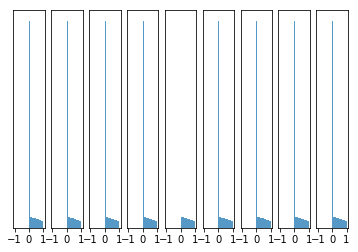

In [28]:
fcs = fc_layer(init_weight=None, use_bn=True)
for idx, fc in enumerate(fcs):
    print('layer {0} mean {1:.5f} and std {2:.5f}'.format(idx+1, np.mean(fc.cpu().numpy()), np.std(fc.cpu().numpy())))

plt.figure()
for idx, fc in enumerate(fcs):
    plt.subplot(1, len(fcs), idx+1)
    plt.yticks([])
    plt.hist(fc.cpu().numpy().flatten(), 30, range=[-1,1], alpha=0.75)

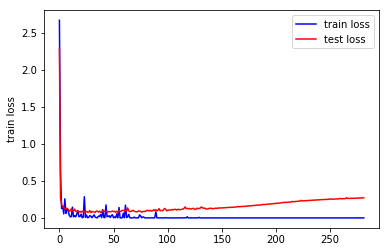

Best Accuracy: 0.984900


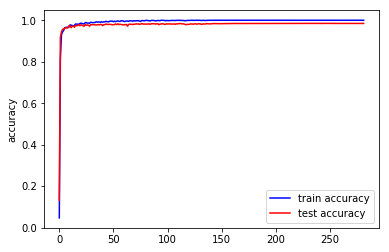

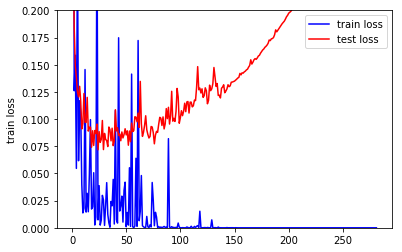

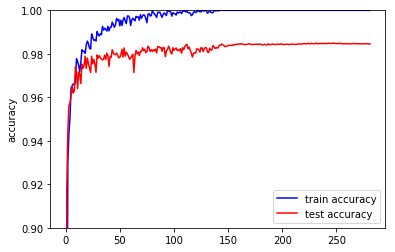

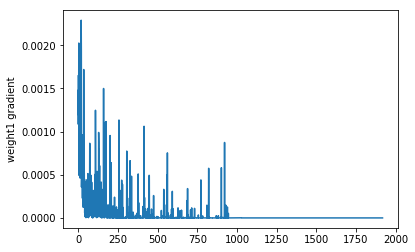

预测错误的图片


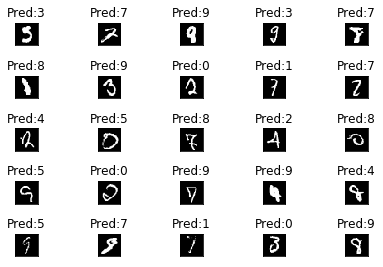

In [29]:
# relu + small learning rate + kaiming he initialize + adam + bn
class MultiLayers(nn.Module):
    def __init__(self):
        super(MultiLayers, self).__init__()
        self.weight1 = Parameter(torch.Tensor(200, 784))
        self.bias1 = Parameter(torch.Tensor(200))
        self.bn1 = nn.BatchNorm1d(num_features=200)
        self.init_weights(self.weight1, self.bias1)
        
        self.weight2 = Parameter(torch.Tensor(100, 200))
        self.bias2 = Parameter(torch.Tensor(100))
        self.bn2 = nn.BatchNorm1d(num_features=100)
        self.init_weights(self.weight2, self.bias2)
        
        self.weight3 = Parameter(torch.Tensor(60, 100))
        self.bias3 = Parameter(torch.Tensor(60))
        self.bn3 = nn.BatchNorm1d(num_features=60)
        self.init_weights(self.weight3, self.bias3)
        
        self.weight4 = Parameter(torch.Tensor(30, 60))
        self.bias4 = Parameter(torch.Tensor(30))
        self.bn4 = nn.BatchNorm1d(num_features=30)
        self.init_weights(self.weight4, self.bias4)
        
        self.weight5 = Parameter(torch.Tensor(10, 30))
        self.bias5 = Parameter(torch.Tensor(10))
        self.init_weights(self.weight5, self.bias5)
        
      
    def init_weights(self, weight, bias):
        nn.init.kaiming_uniform_(weight)
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(bias, -bound, bound)
        
        
    def forward(self, x):
        x = x.matmul(self.weight1.t()) + self.bias1
        x = self.bn1(x)
        x = F.relu(x)
        
        x = x.matmul(self.weight2.t()) + self.bias2
        x = self.bn2(x)
        x = F.relu(x)
        
        x = x.matmul(self.weight3.t()) + self.bias3
        x = self.bn3(x)
        x = F.relu(x)
        
        x = x.matmul(self.weight4.t()) + self.bias4
        x = self.bn4(x)
        x = F.relu(x)
        
        x = x.matmul(self.weight5.t()) + self.bias5
        
        x = F.log_softmax(x, dim=1)
        return x
    
run(MultiLayers, optim="Adam", epoch_num=60, 
    lr=0.003, is_flatten=True, show_log=False, print_weight="weight1", lr_decay=True)

可能当前网络就只能到98%，注意到我们之前对图片做了什么处理，flatten，拉伸成了28 * 28，我们损失了图片的shape信息，能做到98已经是非常amazing的事情了。

# CNN
## Convolutional layer
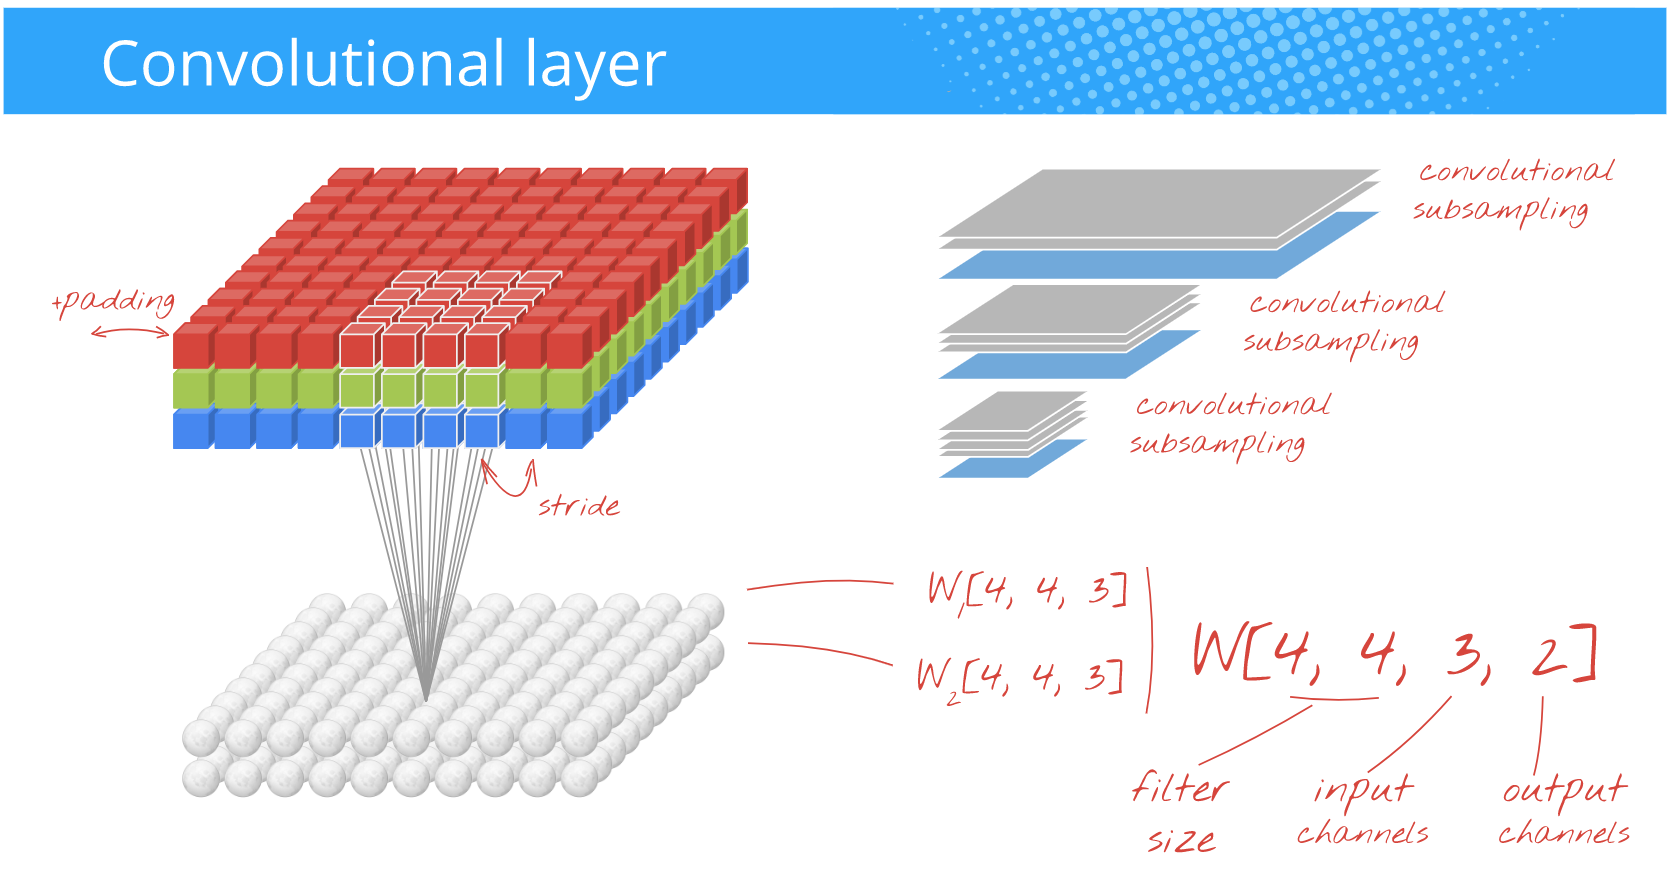这有个问题，尺寸一直是这么大，但是对于输出，我需要的是长度为10的vector，通常我的做法是subsampling，采样。也可以采用stride的方式。

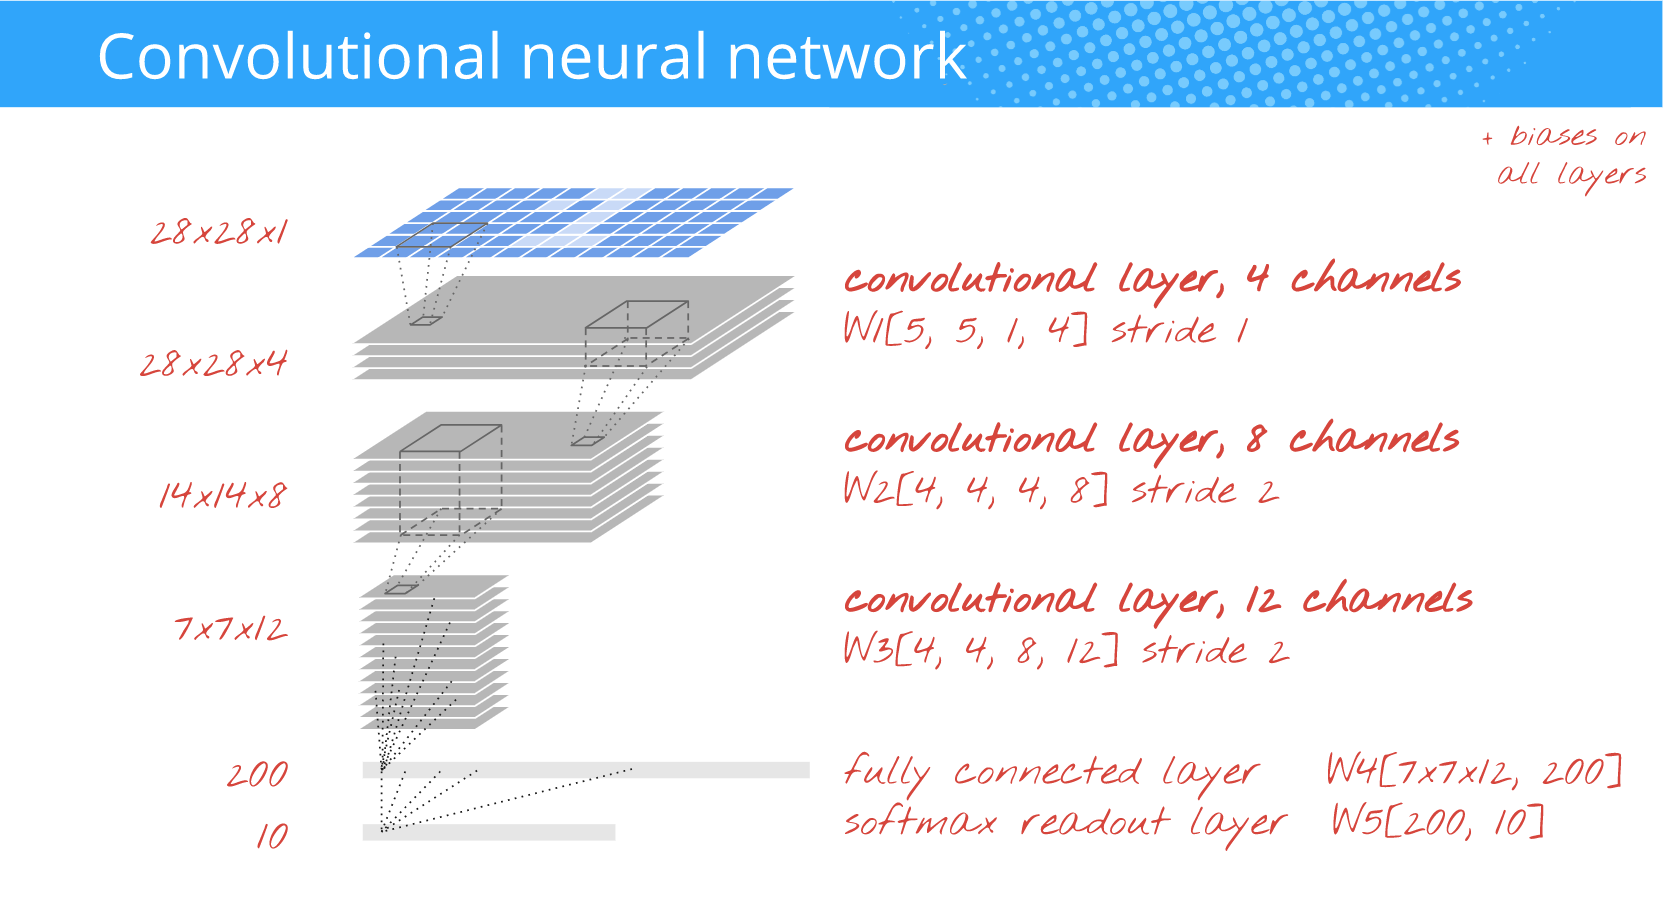

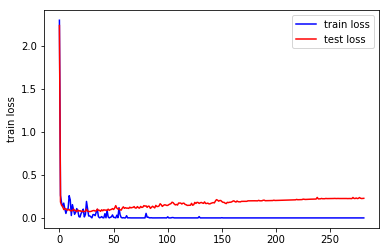

Best Accuracy: 0.984600


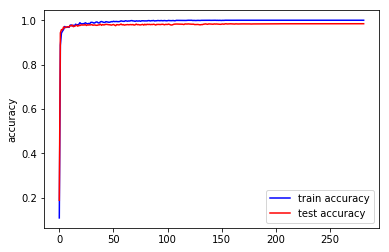

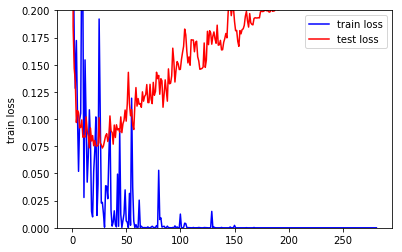

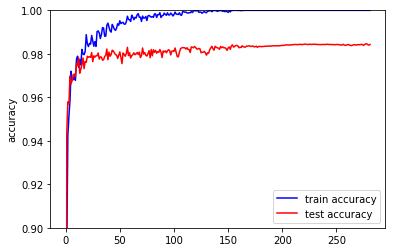

预测错误的图片


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [4, 1, 5, 5], but got input of size [512, 784] instead

In [30]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(8, 12, kernel_size=4, stride=2, padding=1)

        self.fc1 = nn.Linear(7 * 7 * 12, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 7 * 7 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
run(CNN, optim="Adam", epoch_num=60, 
    lr=0.003, is_flatten=False, show_log=False, lr_decay=True)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(12, 24, kernel_size=4, stride=2, padding=1)

        self.fc1 = nn.Linear(7 * 7 * 24, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 7 * 7 * 24)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
run(CNN, optim="Adam", epoch_num=60, 
    lr=0.003, is_flatten=False, show_log=False, lr_decay=True)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(12, 24, kernel_size=4, stride=2, padding=1)

        self.fc1 = nn.Linear(7 * 7 * 24, 200)
        self.fc2 = nn.Linear(200, 10)
        
        self.drop = nn.Dropout(0.75)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 7 * 7 * 24)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
run(CNN, optim="Adam", epoch_num=60, 
    lr=0.003, is_flatten=False, show_log=True, lr_decay=True)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(12, 24, kernel_size=4, stride=2, padding=1)

        self.fc1 = nn.Linear(7 * 7 * 24, 200)
        self.fc2 = nn.Linear(200, 10)
        
        self.bn = nn.BatchNorm1d(num_features=200)
        self.drop = nn.Dropout(0.75)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 7 * 7 * 24)
        x = self.fc1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
run(CNN, optim="Adam", epoch_num=60, 
    lr=0.003, is_flatten=False, show_log=False, lr_decay=True)